In [5]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateEntry
from msrest.authentication import ApiKeyCredentials

ENDPOINT = "my_endpoint"

# # Replace with a valid key
training_key = "my_training_key"
prediction_key = "my_prediction_key"
prediction_resource_id = "my_prediction_resource_id"

publish_iteration_name = "classifyModel"

credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(ENDPOINT, credentials)

# Create a new project
print ("Creating project...")
project = trainer.create_project("My New Project")

Creating project...


In [9]:
import json
import os
from pandas import json_normalize

In [6]:
tags = ['sports ball', 'frisbee', 'bowl', 'orange', 'apple', 'donut']
ball_tag = trainer.create_tag(project.id, "sports ball")
frisbee_tag = trainer.create_tag(project.id, "frisbee")
bowl_tag = trainer.create_tag(project.id, "bowl")
orange_tag = trainer.create_tag(project.id, "orange")
apple_tag = trainer.create_tag(project.id, "apple")
donut_tag = trainer.create_tag(project.id, "donut")

tag_dict = {tags[i]:tag for i, tag in enumerate([ball_tag, frisbee_tag, bowl_tag, orange_tag, apple_tag, donut_tag])}
tag_dict

{'sports ball': <azure.cognitiveservices.vision.customvision.training.models._models_py3.Tag at 0x1f0da4fe788>,
 'frisbee': <azure.cognitiveservices.vision.customvision.training.models._models_py3.Tag at 0x1f0da5058c8>,
 'bowl': <azure.cognitiveservices.vision.customvision.training.models._models_py3.Tag at 0x1f0da507a88>,
 'orange': <azure.cognitiveservices.vision.customvision.training.models._models_py3.Tag at 0x1f0da509b08>,
 'apple': <azure.cognitiveservices.vision.customvision.training.models._models_py3.Tag at 0x1f0da50ea88>,
 'donut': <azure.cognitiveservices.vision.customvision.training.models._models_py3.Tag at 0x1f0da50fa08>}

In [10]:
path = "D:/annotations_subset/instances_train2014.json"
with open(path, 'r') as fp:
    data = json.load(fp)
data.keys()
from pandas import json_normalize
category_ids = json_normalize(data['categories'])
category_ids = category_ids[['id', 'name']]
category_ids = {row['id']: row['name'] for index, row in category_ids.iterrows()}

path = "D:/annotations/instances_train2014.json"
with open(path, 'r') as fp:
    data = json.load(fp)
data.keys()
image_ids = {x['image_id'] : category_ids[x['category_id']] for x in data['annotations'] if x['category_id'] in category_ids.keys()}
bboxes = {x['image_id'] : x['bbox'] for x in data['annotations'] if x['category_id'] in category_ids.keys()}
bboxes = [(x['file_name'],image_ids[x['id']], bboxes[x['id']]) for x in data['images'] if x['id'] in image_ids.keys()]

In [21]:
tagged_images = []
for items in bboxes:
    file_name = items[0]
    filepath = f'D:/train2014_subset/{file_name}'
    tag = items[1]
    with open(filepath, mode='rb') as image_contents:
        tagged_images.append(ImageFileCreateEntry(name=file_name, contents=image_contents.read(), tag_ids=[tag_dict[tag].id]))

In [22]:
# Send in batched of 64
i = 0
while True:
    try:
        imgs = tagged_images[i*64:(i+1)*64]
    except:
        break
    upload_result = trainer.create_images_from_files(project.id, images=imgs)
    if not upload_result.is_batch_successful:
        print("Image batch upload failed.")
        print(i)
        for image in upload_result.images:
            print("Image status: ", image.status)
        exit(-1)
    i += 1

Image batch upload failed.
88
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image s

CustomVisionErrorException: No valid image files

In [23]:
import time

print ("Training...")
iteration = trainer.train_project(project.id)
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(1)

# The iteration is now trained. Publish it to the project endpoint
trainer.publish_iteration(project.id, iteration.id, publish_iteration_name, prediction_resource_id)
print ("Done!")

Training...
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training


In [24]:
path = "D:/annotations_subset/instances_val2014.json"
with open(path, 'r') as fp:
    data = json.load(fp)
data.keys()
from pandas import json_normalize
category_ids = json_normalize(data['categories'])
category_ids = category_ids[['id', 'name']]
category_ids = {row['id']: row['name'] for index, row in category_ids.iterrows()}

path = "D:/annotations/instances_val2014.json"
with open(path, 'r') as fp:
    data = json.load(fp)
data.keys()
val_image_ids = {x['image_id'] : category_ids[x['category_id']] for x in data['annotations'] if x['category_id'] in category_ids.keys()}
val_bboxes = {x['image_id'] : x['bbox'] for x in data['annotations'] if x['category_id'] in category_ids.keys()}
val_bboxes = [(x['file_name'],val_image_ids[x['id']], val_bboxes[x['id']]) for x in data['images'] if x['id'] in val_image_ids.keys()]

In [115]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials
import os
# Now there is a trained endpoint that can be used to make a prediction
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)

score_results = []
classifications = []
actuals = []
probs = []
maps = {x : i for i, x in enumerate(['sports ball', 'frisbee', 'bowl', 'orange', 'apple', 'donut'])}
actuals_for_roc = []
# Open the sample image and get back the prediction results.
for file in os.listdir("D:/val2014_subset"):    
    with open(f"D:/val2014_subset/{file}", mode="rb") as image_contents:
        results = predictor.classify_image(project.id, publish_iteration_name, image_contents.read())
    actual = [x for x in val_bboxes if x[0] == file][0]
    res = []
    for prediction in results.predictions:
        res += [(prediction.tag_name,prediction.probability)]

    res = sorted(res, key = lambda x:x[1], reverse = True)
    score_results += [1] if res[0][0] == actual[1] else [0]
    actuals += [actual[1]]
    classifications += [res[0][0]]
    probs.append([x.probability for x in results.predictions])
    actuals_for_roc += [maps[actual[1]]]

In [116]:
from sklearn import metrics

# Print the confusion matrix
print(metrics.confusion_matrix(actuals, classifications))

# Print the precision and recall, among other metrics
print(metrics.classification_report(actuals, classifications, digits=3))

[[ 123  139   13    5   57    7]
 [  54 1926   65   13   43   18]
 [  11  110  363    8    7    4]
 [   3   16    5  656    2   70]
 [  60  149    9    2  205    5]
 [   9   34    4   98    8 1280]]
              precision    recall  f1-score   support

       apple      0.473     0.358     0.407       344
        bowl      0.811     0.909     0.857      2119
       donut      0.791     0.722     0.755       503
     frisbee      0.839     0.872     0.855       752
      orange      0.637     0.477     0.545       430
 sports ball      0.925     0.893     0.909      1433

    accuracy                          0.816      5581
   macro avg      0.746     0.705     0.721      5581
weighted avg      0.808     0.816     0.809      5581



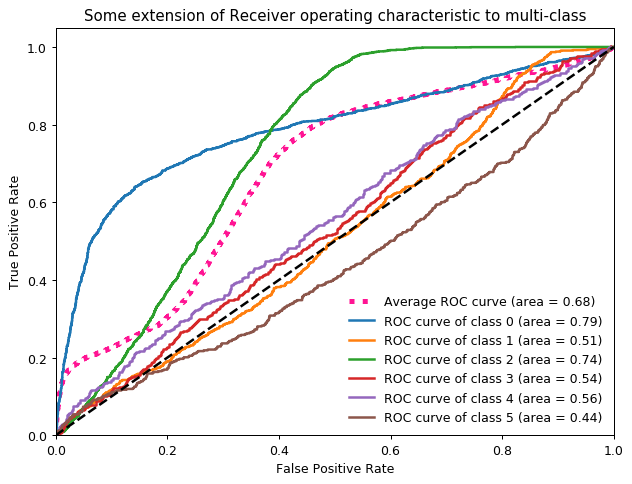

In [117]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

y_predict_proba = np.array(probs)
y_test = np.array(actuals_for_roc)
# Compute ROC curve and ROC AUC for each class
n_classes = 6
fpr = dict()
tpr = dict()
roc_auc = dict()
all_y_test_i = np.array([])
all_y_predict_proba = np.array([])
for i in range(n_classes):
    y_test_i = list(map(lambda x: 1 if x == i else 0, y_test))
    all_y_test_i = np.concatenate([all_y_test_i, y_test_i])
    all_y_predict_proba = np.concatenate([all_y_predict_proba, y_predict_proba[:, i]])
    fpr[i], tpr[i], _ = roc_curve(y_test_i, y_predict_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["average"], tpr["average"], _ = roc_curve(all_y_test_i, all_y_predict_proba)
roc_auc["average"] = auc(fpr["average"], tpr["average"])


# Plot average ROC Curve
plt.figure(figsize = (8,6), dpi = 90)
plt.plot(fpr["average"], tpr["average"],
         label='Average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["average"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot each individual ROC curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right", frameon = False)
plt.show()